## Segmentation-Consistent Probabilistic Lesion Counting 


Step-by-step **example** of the Poisson-binomial counting function proposed in our paper. <br /> 
(For illustration purposes we present a 2D slice, however the extension to 3D images is trivial)


In [1]:
import numpy as np
import torch
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 0. Load Segmentation Output

In [2]:
#Select a 2D slice (for illustration)
segmentation_output = torch.from_numpy(np.load("example_data/sample286_seg_sig.npy")[41,:,:]).to(device) 

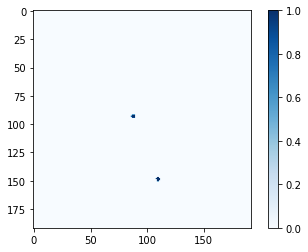

In [3]:
# Display Segmentation Ouput
plt.figure()
plt.imshow(segmentation_output>0.1,vmin=0,vmax=1,cmap='Blues')
plt.colorbar()

#### 1. Lesion Candidates Identification (Section 3.1.1)

Connected Component 

In [4]:
cca_structure = ndimage.generate_binary_structure(2, 2)
binarization_threshold=0.1

# Making sure that no gradient is backpropagated through this step (See Figure 1)
segmentation_output_nograd = segmentation_output.detach().clone()
segmentation_output_nograd.requires_grad = False

cc_output, cc_output_num_features \
    = ndimage.label(segmentation_output_nograd.detach().cpu().numpy()>binarization_threshold,structure=cca_structure)

(Optional) Sized-based Component Filtering

In [5]:
voxel_threshold = 0 #no filtering 
segment_idx, segment_count = np.unique(cc_output, return_counts=True)

# Select Lesion with more than "voxel_threshold" voxels
segment_idx = segment_idx[segment_count>voxel_threshold]
count_sort_idx = np.argsort(-segment_count[segment_count>voxel_threshold])
unique_segment_idx = segment_idx[segment_idx]

Generate Mask for each Component 

In [6]:
cc_output = torch.from_numpy(cc_output).to(device)
mask_list = []

for seg_idx in unique_segment_idx:
    # Ignore background
    if seg_idx > 0:
        with torch.no_grad():
            mask_list.append((cc_output == seg_idx).double())
            
# Stack individual masks
all_masks = torch.stack(mask_list)

#### 2. Lesion Existence Probabilities (Section 3.1.2)

In [7]:
lesion_existence_prob = torch.max(torch.max(all_masks * segmentation_output.unsqueeze(0), dim=1)[0],dim=1)[0] 
#all_max = torch.amax(all_masks * segmentation_output.unsqueeze(0), dim=(1,2)) #for newer torch versions

In [8]:
print(lesion_existence_prob)

tensor([0.5189, 0.7840], dtype=torch.float64)


#### 3. Poisson-binomial Counting (Section 3.1.3)

In [9]:
# https://github.com/SchroeterJulien/ACCV-2020-Subpixel-Point-Localization
def Counting(pred, max_occurence=20):
    contribution = torch.unbind(pred, 1)

    count_prediction = torch.zeros(pred.size()[0], max_occurence, device=device)
    count_prediction[:, 0] = 1  
    for increment in contribution:
        mass_movement = (count_prediction * increment.unsqueeze(1))[:, :max_occurence - 1]
        move = - torch.cat([mass_movement, torch.zeros(count_prediction.size()[0], 1, device=device)], axis=1) \
               + torch.cat([torch.zeros(count_prediction.size()[0], 1, device=device), mass_movement], axis=1)

        count_prediction = count_prediction + move

    return count_prediction

In [10]:
count_distribution = Counting(lesion_existence_prob.unsqueeze(0), max_occurence=5)[0] 
#max_occurence: extent of the count distribution

<BarContainer object of 5 artists>

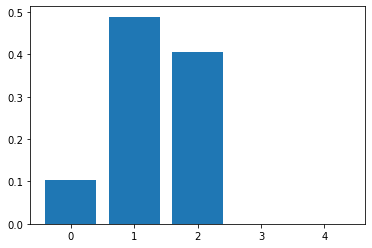

In [11]:
plt.figure()
plt.bar(np.arange(0,5),count_distribution.detach().cpu().numpy())

### Connected Component Benchmark

Same as the beginning of our step 1, except with a higher binarization threshold (see Appendix C.1)

In [12]:
def cc_count(segmentation_output, binarization_threshold=0.5):
    cca_structure = ndimage.generate_binary_structure(2, 2)

    # Making sure that no gradient is backpropagated through this step (See Figure 1)
    segmentation_output_nograd = segmentation_output.detach().clone()
    segmentation_output_nograd.requires_grad = False

    cc_output, cc_output_num_features \
      = ndimage.label(segmentation_output_nograd.detach().cpu().numpy()>binarization_threshold,structure=cca_structure)
    
    return cc_output_num_features

In [13]:
print("CC-prediction (0.5):", cc_count(segmentation_output, binarization_threshold=0.5))

CC-prediction (0.5): 2


In [14]:
print("CC-prediction (0.6):", cc_count(segmentation_output, binarization_threshold=0.6))

CC-prediction (0.6): 1


### Loss Function

In [15]:
import torch.nn.functional as F

def loss_function(count_distribution, label): 
    label_oh =  F.one_hot(torch.from_numpy(np.array([label])).to(torch.int64), num_classes=5)
    return -torch.sum(label_oh * torch.log(count_distribution * label_oh + 1e-12))

In [16]:
loss_function(count_distribution,1)

tensor(0.7149, dtype=torch.float64)

In [17]:
loss_function(count_distribution,2)

tensor(0.8994, dtype=torch.float64)

### 3D Example

In [18]:
from count_function import CountFunction

In [19]:
segmentation_output = torch.from_numpy(np.load("example_data/sample286_seg_sig.npy")).to(device) 

In [20]:
count_distribution, _ = CountFunction(segmentation_output.unsqueeze(0))

<BarContainer object of 5 artists>

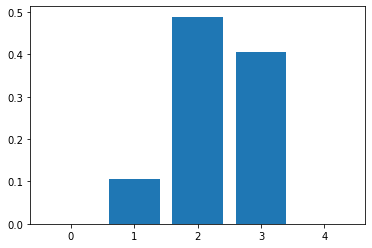

In [21]:
plt.figure()
plt.bar(np.arange(0,5),count_distribution[0].detach().cpu().numpy())

#### 3D function applied on the 2D example

In [22]:
segmentation_output = torch.from_numpy(np.load("example_data/sample286_seg_sig.npy")[41,:,:]).to(device) 
count_distribution, _ = CountFunction(segmentation_output.unsqueeze(0).unsqueeze(3))

In [23]:
count_distribution

tensor([[0.1039, 0.4892, 0.4068, 0.0000, 0.0000]])